# 剥離鉄筋露出(Rebar)Eのセマンティックセグメンテーション

## 実行前のフォルダ構成
- RebarE  
    - Ree_Input  
    - Ree_label  
    - train_img  
    - train_seg  
    - train_arg  
    - trainseg_arg  
    - val_img  
    - val_seg  
    - test_img  

---

## 追加するフォルダ
- RebarE  
    - result_dir  
        - 190912_1502(日付)  
            - train  
                - FWIU.txt
                - IoU.txt
                - Mean_acc.txt
                - Pixcelacc.txt
            - test  
                - FWIU.txt
                - IoU.txt
                - Mean_acc.txt
                - Pixcelacc.txt
            - train_pred
                - Ree0.png, ...
            - test_pred  
                - Ree2.png, ...
            - acc.png
            - loss.png  
        - models
            - UNet
                - training_weight.log
            - FusionNet
                - training_weight.log

In [1]:
##############################################################################################
# セマンティックセグメンテーションのための完全畳み込みネットワークの詳細
# https://fairyonice.github.io/Learn-about-Fully-Convolutional-Networks-for-semantic-segmentation.html
##############################################################################################

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob,os,cv2
from datetime import datetime

%matplotlib inline

BATCH_SIZE = 16
EPOCH = 250


dir_data = "RebarE/"
dir_seg = os.path.join(dir_data, "Ree_label/")
dir_img = os.path.join(dir_data,  "Ree_Input/")

argmentation = False

save_dir = os.path.join("RebarE")
result_dir = os.path.join(save_dir,"result_dir")
os.makedirs(result_dir, exist_ok=True)

time_dir = os.path.join(result_dir,datetime.now().strftime("%y%m%d_%H%M"))
os.makedirs(time_dir, exist_ok=True)
train_pred = os.path.join(time_dir, "train_pred")
os.makedirs(train_pred,exist_ok=True)
test_pred = os.path.join(time_dir, "test_pred")
os.makedirs(test_pred, exist_ok=True)

train_folder = os.path.join(time_dir, 'train')
os.makedirs(train_folder)
test_folder = os.path.join(time_dir, 'test')
os.makedirs(test_folder)

models_dir = os.path.join(result_dir, "models")
os.makedirs(models_dir,exist_ok=True)

if argmentation == True:
    print('argmentationを行います')
    train_img = os.path.join(save_dir, "train_arg")
    train_seg = os.path.join(save_dir, "trainseg_arg")
else:
    print('argmentationを行いません')
    train_img = os.path.join(save_dir, "train_img")
    train_seg = os.path.join(save_dir, "train_seg")

val_img = os.path.join(save_dir, "val_img")
val_seg = os.path.join(save_dir, "val_seg")
test_img = os.path.join(save_dir, "test_img")
test_seg = os.path.join(save_dir, "test_seg")



argmentationを行いません


## Python - [インデックスカラー画像を読み込む方法について](http://pynote.hatenablog.com/entry/opencv-indexed-color-image)

In [2]:
class_names = ["background","RebarE"]
pixelID = [[0,0,0], [128,64,0]]


In [3]:
# 元画像とラベル付けした画像の読み込み
def images_load(original_dir, segmented_dir, init_size):
    # フォルダの画像パスを取得
    origin_filenames = os.listdir(original_dir)
    segmented_filenames = os.listdir(segmented_dir)
    
    images_original, images_segmented = [], []
    
    # 入力画像の読み込み
    print("Loading original images ....")
    for i, origin_filename in enumerate(origin_filenames):
        origin_img = Image.open(os.path.join(original_dir, origin_filename))
        # Crop処理
        origin_img =  crop_to_square(origin_img)
        # resize処理(224,224)
        # 画像中のジャギーを目立たなくする処理
        origin_img = origin_img.resize(init_size, Image.ANTIALIAS)
        # numpy配列に変換
        origin_img = np.asarray(origin_img)
        # normalize処理
        origin_img = origin_img.astype("float")/255.0
        images_original.append(origin_img)
    print("Completed")    
    
    # 教師画像の読み込み
    print("Loading segmented images...")
    for i, seg_filename in enumerate(segmented_filenames):
        seg_img = Image.open(os.path.join(segmented_dir, seg_filename))
        # Crop処理
        seg_img = crop_to_square(seg_img)
        # resize処理
        seg_img = seg_img.resize(init_size)
        # numpy配列に変換
        seg_img = np.asarray(seg_img)
        images_segmented.append(seg_img)
    print("Completed")
    
    # images_originalとimages_segmentedの長さが同じか確かめる
    assert len(images_original) == len(images_segmented)
    
    # numpy配列に変換
    images_original = np.asarray(images_original, dtype=np.float32)
    images_segmented = np.asarray(images_segmented, dtype=np.uint8)
    
    #クラス'void'を 255=>21 に変更
    #images_segmented = np.where(images_segmented>=3, len(class_names)-1, images_segmented)

    # One-hot-encodingを行う
    print("Casting to one-hot encoding...")
    ID = np.zeros((images_segmented.shape[0],images_segmented.shape[1],images_segmented.shape[2]), dtype=np.uint8)
    for num in range(images_segmented.shape[0]):
        for i in range(images_segmented.shape[1]):
            for j in range(images_segmented.shape[2]):
                
                for c in range(len(pixelID)):
                    if all(images_segmented[num][i][j]==pixelID[c]):
                        ID[num][i][j]=c
                
    identity = np.identity(len(class_names), dtype=np.uint8)
    images_segmented = identity[ID]
    print("Done")
    
    print("Input_images Shape :  ", end="")
    print(images_original.shape)
    print("Segmented_images Shape : ", end="")
    print(images_segmented.shape)
    print("")
    return images_original, images_segmented

def crop_to_square(image):
    size = min(image.size)
    left, upper = (image.width - size) // 2, (image.height - size) // 2
    right, bottom = (image.width + size) // 2, (image.height + size) // 2
    return image.crop((left,upper, right,bottom))

In [4]:
print("Load start...")

original_train, segmented_train = images_load(train_img, train_seg, init_size=(224,224))
original_val, segmented_val = images_load(val_img, val_seg, init_size=(224,224))
original_test, segmented_test = images_load(test_img, test_seg, init_size=(224,224))

print("original_train data : ", end="")
print(len(original_train))
print("segmented_train data : ", end="")
print(len(segmented_train))
print("original_validation data : ", end="")
print(len(original_val))
print("segmented_validation data : ", end="")
print(len(segmented_val))
print("original_test data : ", end="")
print(len(original_test))
print("segmented_test data : ", end="")
print(len(segmented_test))

Load start...
Loading original images ....
Completed
Loading segmented images...
Completed
Casting to one-hot encoding...
Done
Input_images Shape :  (93, 224, 224, 3)
Segmented_images Shape : (93, 224, 224, 2)

Loading original images ....
Completed
Loading segmented images...
Completed
Casting to one-hot encoding...
Done
Input_images Shape :  (24, 224, 224, 3)
Segmented_images Shape : (24, 224, 224, 2)

Loading original images ....
Completed
Loading segmented images...
Completed
Casting to one-hot encoding...
Done
Input_images Shape :  (30, 224, 224, 3)
Segmented_images Shape : (30, 224, 224, 2)

original_train data : 93
segmented_train data : 93
original_validation data : 24
segmented_validation data : 24
original_test data : 30
segmented_test data : 30


In [5]:
sum_cnt = np.zeros(segmented_train.shape[3])
sum_cnt

array([0., 0.])

In [6]:
segmented_train.shape

(93, 224, 224, 2)

全画素数を求める

In [7]:
for num in range(segmented_train.shape[0]):
    for i in range(segmented_train.shape[1]):
        for j in range(segmented_train.shape[2]):
            sum_cnt += segmented_train[num][i][j]

In [8]:
sum_cnt

array([1978342., 2688026.])

In [9]:
print(np.sum(sum_cnt))

4666368.0


In [10]:
sum_pixel = segmented_train.shape[0]*segmented_train.shape[1]*segmented_train.shape[2]
print(sum_pixel)

4666368


写真中に含まれるカテゴリの割合を算出する

<BarContainer object of 2 artists>

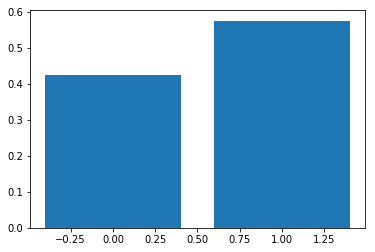

In [11]:
frequency = []
for i in range(len(class_names)):
    frequency.append(sum_cnt[i]/np.sum(sum_cnt))
plt.bar(range(0,len(class_names)),frequency)


## クラス重み付けを行う

In [12]:
classWeights = np.mean(frequency)/frequency
print(classWeights)

[1.17936333 0.8679916 ]


In [13]:
for i in range(len(class_names)):
    print("class {:12s}: #sum_cnt={:10.0f}, #classWeights={:12.8f}".format(class_names[i],sum_cnt[i],classWeights[i]))

class background  : #sum_cnt=   1978342, #classWeights=  1.17936333
class RebarE      : #sum_cnt=   2688026, #classWeights=  0.86799160


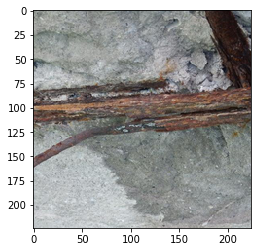

In [14]:
plt.imshow(original_train[21])

In [15]:
print(segmented_train[21][100][100])

[0 1]


## Deep Learningのモデル開発を行う

In [16]:
##################################################################################################
# KerasとTensorflowをインポートして深層学習のFCNモデルを開発する
##################################################################################################
## Import usual libraries
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
#import pandas as pd

warnings.filterwarnings("ignore")
"""
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
#config.gpu_options.visible_device_list = "2"
set_session = tf.Session(config=config)
"""

config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.95
set_session(tf.Session(config=config))

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))



Using TensorFlow backend.


python 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
keras version 2.2.4
tensorflow version 1.12.0


## UNetの定義

In [17]:
class UNet():
    def __init__(self,input_height,input_width,nClasses):
        self.input_height=input_height
        self.input_width=input_width
        self.nClasses=nClasses


    def create_model(self):
        n_filters=64    # originalは64
        kernel_size=3
        dropout=0.5
        batchnorm=True

        # contracting path
        img_input = Input(shape=(self.input_height,self.input_width, 3)) ## Assume 224,224,3
        enc1 = Conv2D(n_filters,kernel_size,padding='same')(img_input)
        if batchnorm:
            enc1 = BatchNormalization()(enc1)
        enc1 = Activation("relu")(enc1)
        enc1 = Conv2D(n_filters,kernel_size,padding='same')(enc1)
        if batchnorm:
            enc1 = BatchNormalization()(enc1)
        enc1 = Activation("relu")(enc1)
        pool1 = MaxPooling2D(pool_size=(2,2))(enc1)
        pool1 = Dropout(dropout*0.5)(pool1)

        enc2 = Conv2D(n_filters*2,kernel_size,padding='same')(pool1)
        if batchnorm:
            enc2 = BatchNormalization()(enc2)
        enc2 = Activation("relu")(enc2)
        enc2 = Conv2D(n_filters*2,kernel_size,padding='same')(enc2)
        if batchnorm:
            enc2 = BatchNormalization()(enc2)
        enc2 = Activation("relu")(enc2)
        pool2 = MaxPooling2D(pool_size=(2,2))(enc2)
        pool2 = Dropout(dropout)(pool2)

        enc3 = Conv2D(n_filters*4,kernel_size,padding='same')(pool2)
        if batchnorm:
            enc3 = BatchNormalization()(enc3)
        enc3 = Activation("relu")(enc3)
        enc3 = Conv2D(n_filters*4,kernel_size,padding='same')(enc3)
        if batchnorm:
            enc3 = BatchNormalization()(enc3)
        enc3 = Activation("relu")(enc3)
        pool3 = MaxPooling2D(pool_size=(2,2))(enc3)
        pool3 = Dropout(dropout)(pool3)

        enc4 = Conv2D(n_filters*8,kernel_size,padding='same')(pool3)
        if batchnorm:
            enc4 = BatchNormalization()(enc4)
        enc4 = Activation("relu")(enc4)
        enc4 = Conv2D(n_filters*8,kernel_size,padding='same')(enc4)
        if batchnorm:
            enc4 = BatchNormalization()(enc4)
        enc4 = Activation("relu")(enc4)
        pool4 = MaxPooling2D(pool_size=(2,2))(enc4)
        pool4 = Dropout(dropout)(pool4)

        enc5 = Conv2D(n_filters*16,kernel_size,padding='same')(pool4)
        if batchnorm:
            enc5 = BatchNormalization()(enc5)
        enc5 = Activation("relu")(enc5)
        enc5 = Conv2D(n_filters*16,kernel_size,padding='same')(enc5)
        if batchnorm:
            enc5 = BatchNormalization()(enc5)
        enc5 = Activation("relu")(enc5)

        # expansive path
        dec1 = Conv2DTranspose(n_filters*8,kernel_size,strides=(2,2),padding='same')(enc5)
        dec1 = concatenate([dec1,enc4],axis=3)
        dec1 = Dropout(dropout)(dec1)
        dec1 = Conv2D(n_filters*8,kernel_size,padding='same')(dec1)
        if batchnorm:
            dec1 = BatchNormalization()(dec1)
        dec1 = Activation("relu")(dec1)
        dec1 = Conv2D(n_filters*8,kernel_size,padding='same')(dec1)
        if batchnorm:
            dec1 = BatchNormalization()(dec1)
        dec1 = Activation("relu")(dec1)

        dec2 = Conv2DTranspose(n_filters*4,kernel_size,strides=(2,2),padding='same')(dec1)
        dec2 = concatenate([dec2,enc3],axis=3)
        dec2 = Dropout(dropout)(dec2)
        dec2 = Conv2D(n_filters*4,kernel_size,padding='same')(dec2)
        if batchnorm:
            dec2 = BatchNormalization()(dec2)
        dec2 = Activation("relu")(dec2)
        dec2 = Conv2D(n_filters*4,kernel_size,padding='same')(dec2)
        if batchnorm:
            dec2 = BatchNormalization()(dec2)
        dec2 = Activation("relu")(dec2)

        dec3 = Conv2DTranspose(n_filters*2,kernel_size,strides=(2,2),padding='same')(dec2)
        dec3 = concatenate([dec3,enc2],axis=3)
        dec3 = Dropout(dropout)(dec3)
        dec3 = Conv2D(n_filters*2,kernel_size,padding='same')(dec3)
        if batchnorm:
            dec3 = BatchNormalization()(dec3)
        dec3 = Activation("relu")(dec3)
        dec3 = Conv2D(n_filters*2,kernel_size,padding='same')(dec3)
        if batchnorm:
            dec3 = BatchNormalization()(dec3)
        dec3 = Activation("relu")(dec3)

        dec4 = Conv2DTranspose(n_filters,kernel_size,strides=(2,2),padding='same')(dec3)
        dec4 = concatenate([dec4,enc1],axis=3)
        dec4 = Dropout(dropout)(dec4)
        dec4 = Conv2D(n_filters,kernel_size,padding='same')(dec4)
        if batchnorm:
            dec4 = BatchNormalization()(dec4)
        dec4 = Activation("relu")(dec4)
        dec4 = Conv2D(n_filters,kernel_size,padding='same')(dec4)
        if batchnorm:
            dec4 = BatchNormalization()(dec4)
        dec4 = Activation("relu")(dec4)

        outputs = Conv2D(self.nClasses,1,activation='sigmoid')(dec4)
        model = Model(inputs=[img_input],output=[outputs])
        return model

#unet = UNet(input_height = 224, input_width  = 224, nClasses = len(class_names))
#model = unet.create_model()
#model.summary()

## FusionNetの定義
[深層学習によるコンクリート護岸劣化領域検出システムの開発](https://www.ipsj.or.jp/dp/contents/publication/38/S1002-S01.html)  
[FusionNet: A deep fully residual convolutional neural network for image segmentation in connectomics](https://arxiv.org/abs/1612.05360)

In [18]:
'''
  1. 畳み込み層
  2. バッチ正規化層
  3. 活性化層
  
  実行例
  
  input_tensor=Input(shape=(224,224,3))
  num_filters=32
  outputs=conv_block(input_tensor, num_filters)
  model = Model(inputs=[input_tensor], outputs=[outputs])
  model.summary()
  '''
def conv_block(input_tensor, num_filters):
  conv = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  conv = BatchNormalization()(conv)
  conv = Activation('relu')(conv)
  return conv


'''
  1. conv_block層(畳み込み+バッチ正規化+活性化)
  2. conv_block層
  3. 畳み込み層
  4. バッチ正規化層
  
  実行例
  
  input_tensor=Input(shape=(224,224,3))
  num_filters=32
  outputs=conv_block_3(input_tensor, num_filters)
  model = Model(inputs=[input_tensor], outputs=[outputs])
  model.summary()
  '''
def conv_block_3(input_tensor, num_filters):
  conv = conv_block(input_tensor, num_filters)
  conv = conv_block(conv,num_filters)
  conv = Conv2D(num_filters,(3,3), padding='same')(conv)
  conv = BatchNormalization()(conv)
  return conv

'''
  Residual block with 3Convolutional layers and
  1 skip connection.
  畳み込み3層の残差ブロック
  
  実行例
  
  input_tensor=Input(shape=(224,224,3))
  num_filters=32
  outputs=Conv_residual_conv(input_tensor, num_filters)
  model = Model(inputs=[input_tensor], outputs=[outputs])
  model.summary()
  '''

def Conv_residual_conv(input_tensor, num_filters):
  conv1 = conv_block(input_tensor, num_filters)
  conv2 = conv_block_3(conv1, num_filters)
  #res = concatenate([conv1,conv2], axis=3)
  res = add([conv1,conv2])
  conv3 = conv_block(res, num_filters)
  return conv3


'''
1. アップサンプリング層
2. バッチ正規化層
3. 活性化層

Upsamplingするときに使用されるレイヤー。
和訳すると「転置畳み込み」。なぜ転置なのかは以下のサイトで分かりやすく説明されている。
https://qiita.com/takurooo/items/9a9f387390f5fcf5a516
'''
def conv_trans_block(input_tensor, num_filters):
  conv = Conv2DTranspose(num_filters,2,strides=(2,2),padding='same')(input_tensor)
  conv = BatchNormalization()(conv)
  conv = Activation('relu')(conv)
  return conv


def FusionNet(input_size, num_filters):
  print("Builiding FusionNet...")
  input_tensor = Input(shape=(input_size[0],input_size[1],3))
  
  # No.1 encoder
  enc1 = Conv_residual_conv(input_tensor, num_filters)
  pool1 = MaxPooling2D(pool_size=(2,2))(enc1)
  enc2 = Conv_residual_conv(pool1, num_filters*2)
  pool2 = MaxPooling2D(pool_size=(2,2))(enc2)
  enc3 = Conv_residual_conv(pool2, num_filters*4)
  pool3 = MaxPooling2D(pool_size=(2,2))(enc3)
  enc4 = Conv_residual_conv(pool3, num_filters*8)
  pool4 = MaxPooling2D(pool_size=(2,2))(enc4)
  
  # No.2 bridge
  bridge = Conv_residual_conv(pool4, num_filters*16)
  
  # No.3 decoder
  dec1 = conv_trans_block(bridge, num_filters*8)
  skip1 = add([dec1, enc4])
  up1 = Conv_residual_conv(skip1, num_filters*8)
  
  dec2 = conv_trans_block(up1, num_filters*4)
  skip2 = add([dec2,enc3])
  up2 = Conv_residual_conv(skip2, num_filters*4)
  
  dec3 = conv_trans_block(up2, num_filters*2)
  skip3 = add([dec3,enc2])
  up3 = Conv_residual_conv(skip3, num_filters*2)
  
  dec4 = conv_trans_block(up3, num_filters)
  skip4 = add([dec4, enc1])
  up4 = Conv_residual_conv(skip4, num_filters)
  
  # No.4 output
  outputs = Conv2D(len(class_names), (3, 3), padding='same', activation='softmax')(up4)
  
  return Model(inputs=[input_tensor], outputs=[outputs])

#input_size = 224  # 入力サイズ (224,224,3)
#num_filters=32
#model=FusionNet(input_size, num_filters)
#model.summary()

## 使用するモデルを選択する(UNet or FusionNet)

In [ ]:
use_model = 'UNet'  # UNet または FusionNet と記載する

In [19]:


if use_model == 'UNet':
    print('Unetが選択されました。')
    dir_unet = os.path.join(models_dir, 'UNet')
    os.makedirs(dir_unet, exist_ok=True)
    model_path = os.path.join(dir_unet, datetime.now().strftime('%y%m%d_%H%M')+'.h5')
    print('モデルの重みを保存しているパス: ', model_path)
    
    unet = UNet(input_height = 224, input_width  = 224, nClasses = len(class_names))
    model = unet.create_model()
    model.summary()
    
elif use_model == 'FusionNet':
    print('FusionNetが選択されました。')
    dir_fusionnet = os.path.join(models_dir, 'FusionNet')
    os.makedirs(dir_fusionnet, exist_ok=True)
    model_path = os.path.join(dir_fusionnet, datetime.now().strftime('%y%m%d_%H%M')+'.h5')
    print('モデルの重みを保存しているパス: ', model_path)
    
    input_size = (224,224)  # 入力サイズ (224,224,3)
    num_filters=64
    model=FusionNet(input_size, num_filters)
    model.summary()

Unetが選択されました。
モデルの重みを保存しているパス:  RebarE\result_dir\models\UNet\190916_1107.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 64) 0           batch_normalization_1[0][0]      
________________________________

## モデルの訓練を開始する  
予め保存した重みを使う場合はスキップ

In [20]:
#############################################################################################################################################
# トレーニング開始
#############################################################################################################################################
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau,CSVLogger   # 追加

#adam = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
adam = optimizers.Adam()
#sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

#model.compile(loss=dice_loss,optimizer=sgd,metrics=[dice_coef])
# 学習が進まなくなった際に学習率を減らす
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 4, min_lr=1e-5, verbose = 1)

# 過学習の抑制 (val_lossが patience epoch 減らない場合、学習の停止)
#early_stopping = EarlyStopping(monitor = 'val_loss', patience = 12 , verbose = 1) 

# モデルの保存先を指定 前のセルで実行
#model_path = os.path.join(save_dir, 'UNet_adam_Weight_model.h5') 

# 評価に用いるモデルの保存
checkpointer = ModelCheckpoint(model_path, monitor = 'val_loss', verbose = 0, save_best_only = True)
# 各エポックの結果をcsvファイルに保存するコールバック関数
checkpointer = ModelCheckpoint(model_path, monitor = 'val_loss', verbose = 0, save_best_only = True)
# 各エポックの結果をcsvファイルに保存するコールバック関数
csv_logger = CSVLogger(os.path.join(models_dir,use_model,datetime.now().strftime('%y%m%d_%H%M') +'.log'))
#es_cb = EarlyStopping(monitor='val_loss', patience=5,verbose=1,mode='auto')  # 追加
#chkpt = os.path.join(dir_data,'FCN_.{epoch:03d}-{val_loss:.2f}.hdf5')       # 追加
#cp_cb = ModelCheckpoint(filepath=chkpt, monitor='val_loss', verbose=1, save_best_only=True,mode='auto') # 追加

# クラス重み付けをするかどうか
class_weight = True

if class_weight:
    print("クラス重み付けを行います")
    class_weights = classWeights
else:
    print("クラス重み付けを行いません")
    class_weights = None

# BATCH_SIZE, EPOCHはプログラムの先頭で宣言
hist1 = model.fit(original_train, segmented_train,
                  validation_data=(original_val,segmented_val),
                  batch_size=BATCH_SIZE//4,
                  epochs=EPOCH,
                  verbose=1,
                  shuffle=True,
                  callbacks=[checkpointer,csv_logger],
                  class_weight=class_weights
                  )
                #callbacks=[es_cb,cp_cb]
    
print("Training finish!")

# モデルの保存
open(os.path.join(models_dir,use_model,datetime.now().strftime('%y%m%d_%H%M') +'.json'),"w").write(model.to_json())
model.save_weights(model_path)

クラス重み付けを行います
Train on 93 samples, validate on 24 samples
Epoch 1/250
93/93 [==============================] - 20s 216ms/step - loss: 0.6711 - acc: 0.6006 - val_loss: 0.7354 - val_acc: 0.5375
Epoch 2/250
93/93 [==============================] - 10s 106ms/step - loss: 0.5681 - acc: 0.7061 - val_loss: 0.5771 - val_acc: 0.7679
Epoch 3/250
93/93 [==============================] - 10s 106ms/step - loss: 0.5364 - acc: 0.7325 - val_loss: 1.7950 - val_acc: 0.6343
Epoch 4/250
93/93 [==============================] - 10s 106ms/step - loss: 0.5453 - acc: 0.7273 - val_loss: 0.6932 - val_acc: 0.4324
Epoch 5/250
93/93 [==============================] - 10s 109ms/step - loss: 0.5144 - acc: 0.7456 - val_loss: 1.2545 - val_acc: 0.5874
Epoch 6/250
93/93 [==============================] - 10s 108ms/step - loss: 0.5231 - acc: 0.7248 - val_loss: 1.2681 - val_acc: 0.6555
Epoch 7/250
93/93 [==============================] - 10s 106ms/step - loss: 0.5138 - acc: 0.7483 - val_loss: 0.7287 - val_acc: 0.5218
Epoch

## 1epochごとに正解率と損失の変化をプロットする

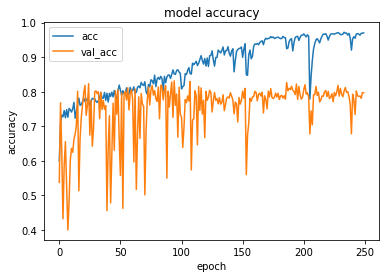

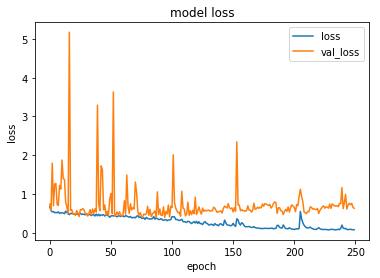

In [21]:
######################################################################################################################################
# 1epochごとに正解率と損失の変化をプロットする
#######################################################################################################################################
for key in ['acc', 'val_acc']:
    plt.plot(hist1.history[key],label=key)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(time_dir, 'acc.png'))
plt.show()

for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(time_dir, 'loss.png'))
plt.show()



## [モデルを読み込む](https://algorithm.joho.info/machine-learning/python-keras-save-load/)  


## 訓練をした結果の精度を算出する

In [22]:
class evaluate:
    def IoU(Yi,y_predi,folder):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

        with open(os.path.join(folder,'IoU.txt'),'w') as f:
            IoUs = []
            Nclass = int(np.max(Yi)) + 1
            for c in range(Nclass):
                TP = np.sum( (Yi == c)&(y_predi==c) )
                FP = np.sum( (Yi != c)&(y_predi==c) )
                FN = np.sum( (Yi == c)&(y_predi != c))
                IoU = TP/float(TP + FP + FN)
                f.write("class {:12s}: #TP={:8.0f}, #FP={:8.0f}, #FN={:8.0f}, IoU={:4.3f}".format(class_names[c],TP,FP,FN,IoU))
                f.write("\n")
                IoUs.append(IoU)
            mIoU = np.mean(IoUs)
            f.write("_________________")
            f.write("\n")
            f.write("Mean IoU: {:4.3f}".format(mIoU))
            f.write("\n")
            print("Mean IoU: {:4.3f}".format(mIoU))

    def PixelWise_acc(Yi,y_predi,folder):
        with open(os.path.join(folder,'Pixcelacc.txt'),'w') as f:
            # 画像の全画素数(縦 * 横)
            N = Yi.shape[1] * Yi.shape[2]
            # 1枚ごとの精度を保存する箱
            accuracies = []

            # 1枚ずつ精度を計算
            for i,testlabel in enumerate(Yi):
                # 正解画素数を計算
                Ni = np.sum(y_predi[i] == testlabel)
                # 精度の計算
                accuracy = Ni / N
                f.write("image {:02.0f}: #正解画素数={:6.0f}, #全画素数={:6.0f}, accuracy={:4.3f}".format(i,Ni,N,accuracy))
                f.write("\n")
                accuracies.append(accuracy)
            PixelWise_acc = np.mean(accuracies)
            f.write("_________________")
            f.write("\n")
            f.write("Pixel-wise Accuracy: {:4.3f}".format(PixelWise_acc))
            f.write("\n")
            print("Pixel-wise Accuracy: {:4.3f}".format(PixelWise_acc))
            
    def Mean_acc(Yi,y_predi,folder):
        with open(os.path.join(folder,'Mean_acc.txt'), 'w') as f:
            accuracies = []
            Nclass = int(np.max(Yi)) + 1
            for i in range(Nclass):
                # クラスiの正解画素数
                Ti = np.sum(Yi==i)
                # 予測した画像のクラスiの画素数
                Ni = np.sum((Yi==i)&(y_predi==i))
                # クラスごとの正解率の計算
                accuracy = Ni / Ti
                f.write("class {:12s}: #Ni={:6.0f}, #Ti={:6.0f}, Mean_acc={:4.3f}".format(class_names[i],Ni,Ti,accuracy))
                f.write("\n")
                accuracies.append(accuracy)
            Mean_acc = np.mean(accuracies)
            f.write("_________________")
            f.write("\n")
            f.write("Mean Accuracy: {:4.3f}".format(Mean_acc))
            f.write("\n")
            print("Mean Accuracy: {:4.3f}".format(Mean_acc))

    def FWIU(Yi,y_predi,folder):
        with open(os.path.join(folder,'FWIU.txt'), 'w') as f:
            accuracies=0
            N = Yi.shape[0]*Yi.shape[1] * Yi.shape[2]
            Nclass = int(np.max(Yi)+1)
            for i in range(Nclass):
                accuracy=0
                Ti = np.sum(Yi==i)
                Ni = np.sum((Yi==i)&(y_predi==i))
                accuracy = Ni/(Ti+np.sum(y_predi==i)-Ni)*Ti
                f.write("class {:12s}: #Ni={:7.0f}, #Ti={:7.0f}, f.w.IU={:10.3f}".format(class_names[i],Ni,Ti,accuracy))
                f.write("\n")
                accuracies+=accuracy
            fwIU = accuracies/N
            f.write("_________________")
            f.write("\n")
            f.write("N {:10f}".format(N))
            f.write("\n")
            f.write("FWIU: {:4.3f}".format(fwIU))
            f.write("\n")
            print("FWIU: {:4.3f}".format(fwIU))

In [23]:
# U-Net, 重みづけ無, 水増し無
#model.load_weights(os.path.join(save_dir,"UNet_NonWeight_model.h5"))
# U-Net, 重みづけ有, 水増し無
#model.load_weights(os.path.join(save_dir,"UNet_Weight_model.h5"))

#################################################################################
# 訓練画像を用いて評価した時
#################################################################################
#train_folder = os.path.join(time_dir, 'train')
x_pred = model.predict(original_train)
x_predi = np.argmax(x_pred, axis=3)
x_testi = np.argmax(segmented_train, axis=3)
print("x_testi.shape, x_predi.shape: ", end="")
print(x_testi.shape,x_predi.shape)

evaluate.IoU(x_testi,x_predi,train_folder)
evaluate.PixelWise_acc(x_testi,x_predi,train_folder)
evaluate.Mean_acc(x_testi,x_predi,train_folder)
evaluate.FWIU(x_testi,x_predi,train_folder)

#################################################################################
# 訓練画像を用いて評価した時
#################################################################################
#test_folder = os.path.join(result_dir, 'test')
y_pred = model.predict(original_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(segmented_test, axis=3)
print("y_testi.shape, y_predi.shape: ", end="")
print(y_testi.shape,y_predi.shape)

evaluate.IoU(y_testi,y_predi,test_folder)
evaluate.PixelWise_acc(y_testi,y_predi,test_folder)
evaluate.Mean_acc(y_testi,y_predi,test_folder)
evaluate.FWIU(y_testi,y_predi,test_folder)

x_testi.shape, x_predi.shape: (93, 224, 224) (93, 224, 224)
Mean IoU: 0.955
Pixel-wise Accuracy: 0.978
Mean Accuracy: 0.976
FWIU: 0.956
y_testi.shape, y_predi.shape: (30, 224, 224) (30, 224, 224)
Mean IoU: 0.687
Pixel-wise Accuracy: 0.831
Mean Accuracy: 0.809
FWIU: 0.714


In [24]:
# 0番目のテスト画像の縦横それぞれ100画素目の結果
y_pred[0][100][100]

#array([0.21871884, 0.7812812 ], dtype=float32)
#21.9%の確率でbackground(背景), 78.1%の確率でRebarE(剥離鉄筋露出-E)

array([0.00393313, 0.743394  ], dtype=float32)

## テスト画像にセマンティックセグメンテーションを適用した出力結果

In [25]:
def output_img(y_pred,pre_input,pre_output):
    filenames_predict = os.listdir(pre_input)
    for num in range(y_pred.shape[0]):
        #img = cv2.imread(os.path.join(pre_input,filenames_predict[num]))
        # num番目の画像を対象
        y = y_pred[num]
        y = np.argmax(y, axis=2)
        pre_img = np.empty((224,224,3),dtype=np.uint8)
        
        for i in range(224):
            for j in range(224):
                pre_img[i][j] = pixelID[y[i][j]]
        pre_img = Image.fromarray((np.uint8(pre_img)))
        
        # 画像書き込み
        pre_img.save(os.path.join(pre_output,filenames_predict[num][:-4] + '.png'))
        #cv2.imwrite(os.path.join(pre_output,filenames_predict[num][:-4] + '.png'), pre_img)

In [26]:
output_img(x_pred,train_img,train_pred)
output_img(y_pred,test_img,test_pred)

練習

In [ ]:
pre_img = np.empty((224,224,3), dtype=np.uint8)

for i in range(224):
    for j in range(224):
        pre_img[i][j] = palette[1]
pre_img = Image.fromarray((np.uint8(pre_img)))
pre_img.save('example.png')
